In [1]:
try:
    image_path
except NameError:
    image_path = 'sample-flowcharts/fc1.jpeg'

In [2]:
import cv2
import numpy as np
import math
import os
from matplotlib import pyplot as plt

In [3]:
# Helper methods
def denoiseAndFill(m, thres):
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    denoise = np.zeros_like(m)
    for contour in contours:
        if cv2.contourArea(contour) > thres:
            cv2.drawContours(denoise, [contour], -1, 255, thickness=cv2.FILLED)
    return denoise

def rotate(m, lines):
    angles = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = math.atan2(y2 - y1, x2 - x1)
            angles.append(angle)
    angles.sort()
    majority_angles = findMajority(np.array(angles), 10)
    angle = np.median(majority_angles)
    degree = math.degrees(angle)

    # Rotate image
    (h, w) = m.shape[:2]
    center = (w // 2, h // 2)
    rotMat = cv2.getRotationMatrix2D(center, degree, 1.0)
    rotated = cv2.warpAffine(m, rotMat, (w, h), flags=cv2.INTER_LINEAR)
    return rotated

def findMajority(input_angles, splits):
    pi = math.pi
    bins = np.linspace(-pi/2, pi/2, splits+1)
    hist, bin_edges = np.histogram(input_angles, bins)
    max_bin = np.argmax(hist)
    mask = (input_angles >= bin_edges[max_bin]) & (input_angles < bin_edges[max_bin+1])
    majority = input_angles[mask]
    return majority

def dilate(m, r):
    se = seGen(r)
    dilated = cv2.dilate(m, se)
    return dilated

def erode(m, r):
    se = seGen(r)
    eroded = cv2.erode(m, se)
    return eroded

def seGen(radius):
    diameter = 2 * radius + 1
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (diameter, diameter))
    return se

def genRectAndDiam(m):
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangle = np.zeros_like(m)
    diamond = np.zeros_like(m)
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        rect_area = w * h
        if area / rect_area > 0.75:
            cv2.drawContours(rectangle, [contour], -1, 255, thickness=cv2.FILLED)
        else:
            cv2.drawContours(diamond, [contour], -1, 255, thickness=cv2.FILLED)
    return rectangle, diamond

def plot_image(img, title):
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.title(title)
    plt.show()

In [4]:
def SE_opening(radius):
        diameter = 2 * radius + 1
        se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (diameter, diameter))
        return se

def prepro(mat):
    plot_image(mat, "Original Image")
    rows, cols = mat.shape[:2]

    # Convert to grayscale
    gray = cv2.cvtColor(mat, cv2.COLOR_RGB2GRAY)
    plot_image(gray, "Grayscale Image")

    # Adaptive thresholding (binarization)
    bina = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 65, 40)
    plot_image(bina, "Binarized Image")

    # Bitwise inversion
    bina = cv2.bitwise_not(bina)
    plot_image(bina, "Bitwise Inverted Image")


    # Denoise and fill
    denoise = denoiseAndFill(bina, 100)
    plot_image(denoise, "After denoising and fill")

    # Edge detection
    edges = cv2.Canny(denoise, 100, 100, apertureSize=3, L2gradient=False)
    plot_image(edges, "Detected Edges")

    # Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180.0, 50, minLineLength=30, maxLineGap=5)
    if lines is not None and len(lines) > 0:
        rotated = rotate(denoise, lines)
        substitute = rotated.copy()
        rows, cols = substitute.shape[:2]
    else:
        substitute = denoise.copy()
    plot_image(substitute, "Rotated Image")

    # Fill small regions
    fill = denoiseAndFill(substitute, 100)

    # Morphological opening to eliminate arrows
    seOpen = seGen(10)
    opened = cv2.morphologyEx(fill, cv2.MORPH_OPEN, seOpen)
    opened = denoiseAndFill(opened, 100)
    plot_image(opened, "Opened Image")

    # Compute difference to get arrows
    diff = cv2.absdiff(fill, opened)
    plot_image(diff, "Arrows")

    # Remove small areas generated by opening
    remv = denoiseAndFill(diff, 50)
    arro = cv2.dilate(remv, SE_opening(2))
    plot_image(arro, "Enhanced Arrows")

    # Extract rectangles and diamonds
    blob = cv2.absdiff(fill, remv)

    # Find circles
    eroded_blob = erode(blob, 10)
    diff_blob = cv2.absdiff(blob, eroded_blob)
    copy_blob = diff_blob.copy()
    contours, _ = cv2.findContours(diff_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        temp = np.zeros_like(diff_blob)
        cv2.drawContours(temp, [contour], -1, 255, 10)
        circles = cv2.HoughCircles(temp, cv2.HOUGH_GRADIENT, 2, substitute.shape[0]/4, param1=200, param2=100, minRadius=0, maxRadius=0)
        if circles is not None and len(circles) > 0:
            cv2.fillPoly(copy_blob, [contour], 0)
    circ = cv2.absdiff(diff_blob, copy_blob)

    # Distinguish rectangles and diamonds
    rect, diam = genRectAndDiam(copy_blob)

    # Erode
    eroded_rect = erode(rect, 10)
    eroded_diam = erode(diam, 10)

    # Get final rectangles and diamonds
    rect = cv2.absdiff(rect, eroded_rect)
    diam = cv2.absdiff(diam, eroded_diam)

    # Final result
    result = [rect, diam, arro, circ]
    plot_image(rect, "Rectangles")
    plot_image(diam, "Diamonds")
    plot_image(circ, "Circles")
    plot_image(arro, "Arrows")
    return result

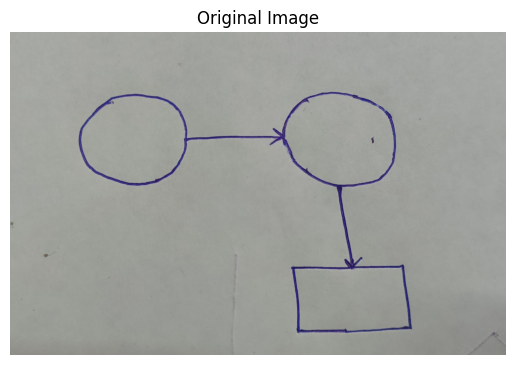

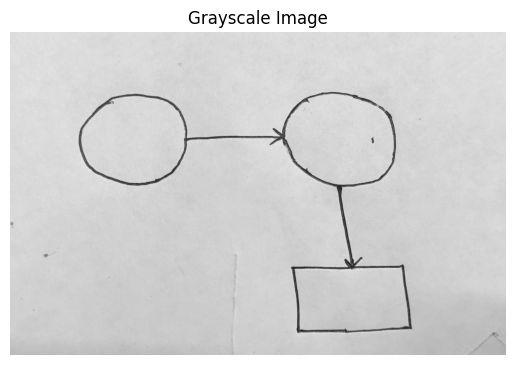

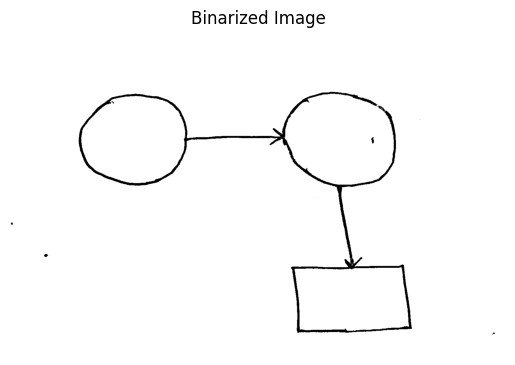

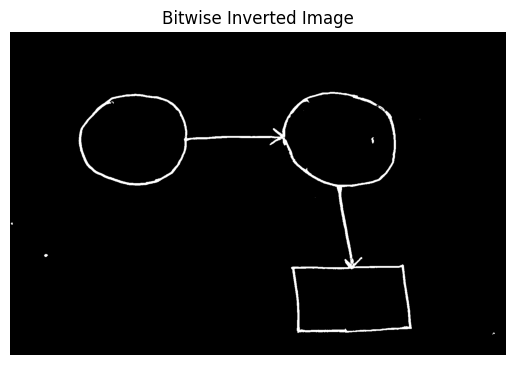

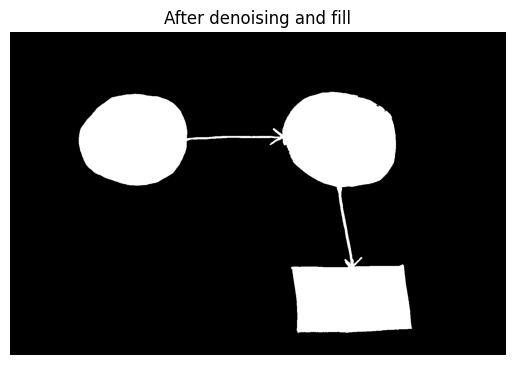

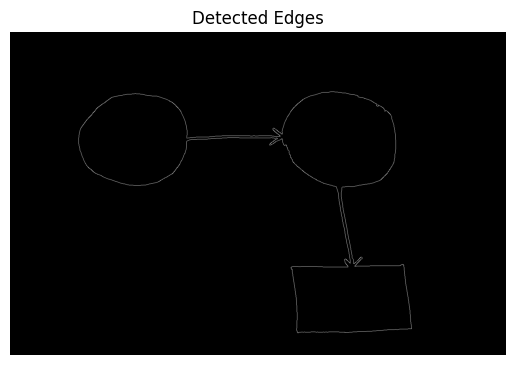

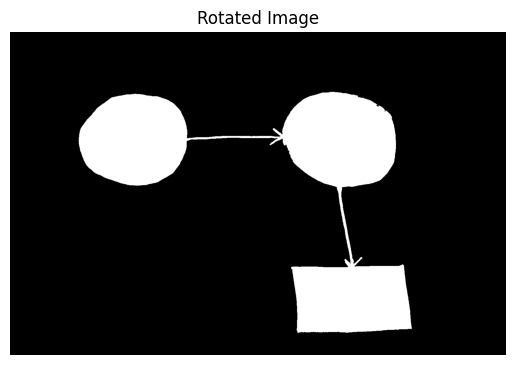

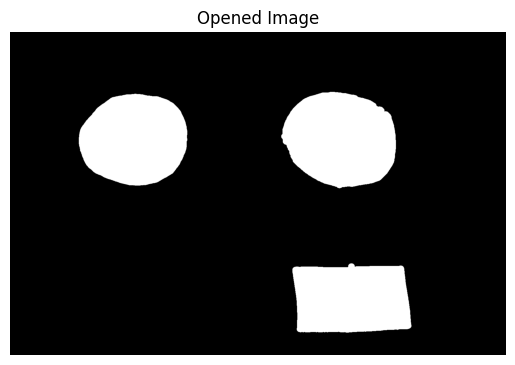

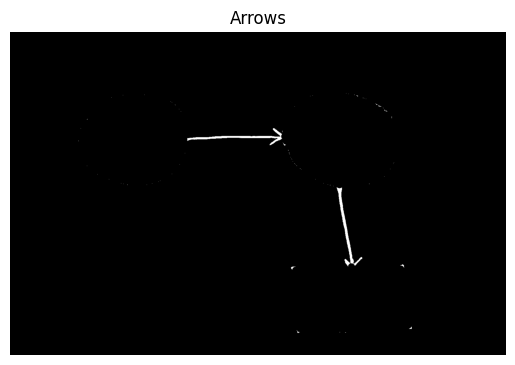

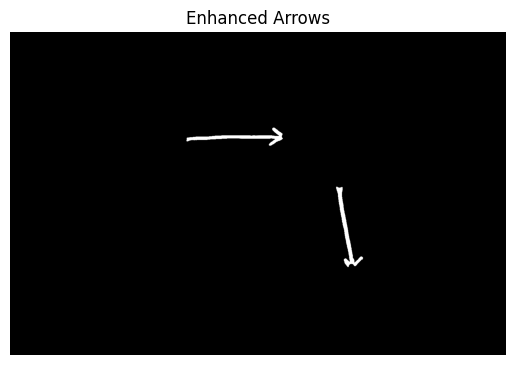

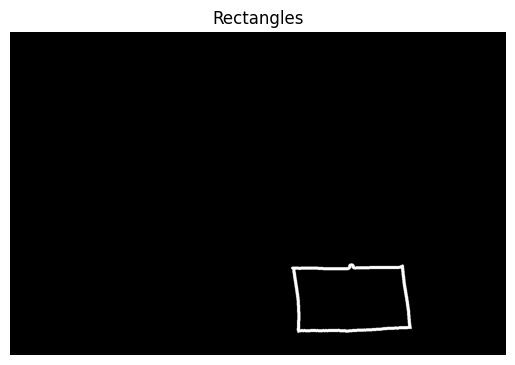

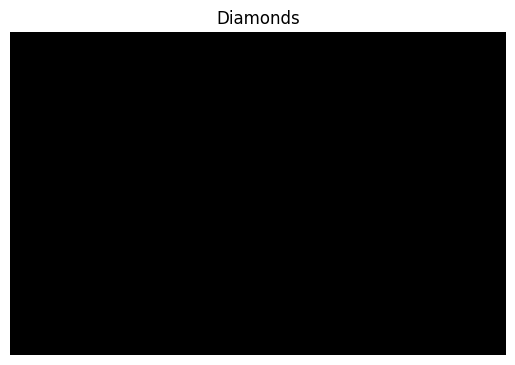

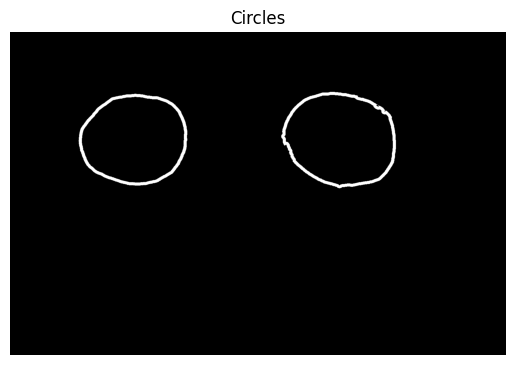

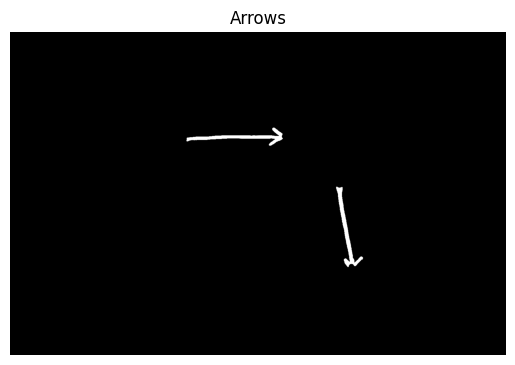

In [5]:
fc = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
result = prepro(fc)

In [6]:
def rectangle_stats(rectangles):
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(rectangles)
    num = n_labels-1
    center = centroids[1:].astype(int)
    anchors = stats[1:, [2,3]]
    coordinates = {"RT": [], "RB": [], "LT": [], "LB": []}
    for i in range(num):
        w, h = anchors[i]
        rt = (center[i][0] + w//2, center[i][1] + h//2)
        coordinates["RT"].append(rt)
        rb = (center[i][0] + w//2, center[i][1] - h//2)
        coordinates["RB"].append(rb)
        lt = (center[i][0] - w//2, center[i][1] + h//2)
        coordinates["LT"].append(lt)
        lb = (center[i][0] - w//2, center[i][1] - h//2)
        coordinates["LB"].append(lb)
    return (num, center, coordinates)

def diamond_stats(diamonds):
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(diamonds)
    num = n_labels-1
    center = centroids[1:].astype(int)
    anchors = stats[1:, [2,3]]
    coordinates = {"Top": [], "Bottom": [], "Left": [], "Right": []}
    for i in range(num):
        w, h = anchors[i]
        top = (center[i][0], center[i][1] + h//2)
        coordinates["Top"].append(top)
        bottom = (center[i][0], center[i][1] - h//2)
        coordinates["Bottom"].append(bottom)
        left = (center[i][0] - w//2, center[i][1])
        coordinates["Left"].append(left)
        right = (center[i][0] + w//2, center[i][1])
        coordinates["Right"].append(right)
    return (num, center, coordinates)

def circle_stats(circles):
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(circles)
    num = n_labels-1
    center = centroids[1:].astype(int)
    anchors = stats[1:, [2,3]]
    coordinates = {"Top": [], "Bottom": [], "Left": [], "Right": [], "Radius": []}
    for i in range(num):
        w, h = anchors[i]
        top = (center[i][0], center[i][1] + h//2)
        coordinates["Top"].append(top)
        bottom = (center[i][0], center[i][1] - h//2)
        coordinates["Bottom"].append(bottom)
        left = (center[i][0] - w//2, center[i][1])
        coordinates["Left"].append(left)
        right = (center[i][0] + w//2, center[i][1])
        coordinates["Right"].append(right)
        radius = (w+h)//4
        coordinates["Radius"].append(radius)
    return (num, center, coordinates)

def arrow_stats(arrows):
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(arrows)
    num = n_labels-1

    if num == 0:
      raise Exception
  
    center = centroids[1:].astype(int)
    anchors = stats[1:, [2,3]]
    coordinates = {"Tail": [], "Head": []}
    for i in range(num):
        x = stats[i+1, cv2.CC_STAT_LEFT]
        y = stats[i+1, cv2.CC_STAT_TOP]
        w = stats[i+1, cv2.CC_STAT_WIDTH]
        h = stats[i+1, cv2.CC_STAT_HEIGHT]
        center_x, center_y = center[i]

        box_X = x + 0.5 * w
        box_Y = y + 0.5 * h

        if w > h:
          if center_x < box_X:
            head = [x, y]
            tail = [x + w, y]
          else:
            head = [x + w, y]
            tail = [x, y]
        else:
            if center_y < box_Y:
              head = [x, y]
              tail = [x, y + h]
            else:
              head = [x, y + h]
              tail = [x, y]
        coordinates["Head"].append(head)
        coordinates["Tail"].append(tail)
    return (num, center, coordinates)

In [7]:
[rectangles, diamonds, arrows, circles] = result

In [8]:
shape_stats = [rectangle_stats(rectangles), diamond_stats(diamonds), circle_stats(circles), arrow_stats(arrows)]

In [9]:
# Create a canvas to draw the flowchart on
flowchart_canvas = np.ones(fc.shape, dtype="uint8") * 255
shapes = shape_stats[:3]
arrows = shape_stats[3]

# Draw all the shapes first
  # First up: Rectangles
for i in range(0, shapes[0][0]):
  cv2.rectangle(flowchart_canvas, shapes[0][2]["LT"][i], shape_stats[0][2]["RB"][i], (255, 0, 0), thickness=3)

  # Next up: Diamonds
for i in range(0, shapes[1][0]):

  points = np.array([
    shapes[1][2]["Top"][i],
    shapes[1][2]["Right"][i],
    shapes[1][2]["Bottom"][i],
    shapes[1][2]["Left"][i],
  ])
  
  cv2.polylines(flowchart_canvas, [points], isClosed=True, color=(0, 255, 0), thickness=3)
  
  # Next up: Circles
for i in range(0, shapes[2][0]):
  cv2.circle(flowchart_canvas, shapes[2][1][i], shapes[2][2]["Radius"][i], (0, 255, 0), thickness=3)


  # Finally, we go for the Arrows:
for i in range(0, arrows[0]):
  cv2.arrowedLine(flowchart_canvas, arrows[2]["Tail"][i], arrows[2]["Head"][i], (0, 255, 255), thickness=3, tipLength=0.2)

[[ 748  338]
 [1084  641]]


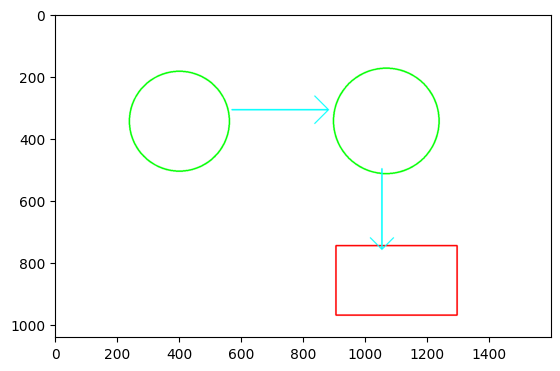

In [10]:
plt.imshow(flowchart_canvas)

print(arrows[1])

In [ ]:
cv2.imwrite("output-flowchart.png", flowchart_canvas)